<a href="https://colab.research.google.com/github/SonLee369/DSPD22VT/blob/main/DSPSP25PRJB22DCVT439.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Chủ đề 04: Xử lý tín hiệu trong ứng dụng AI
# Project: Phân loại âm thanh môi trường với mô hình học sâu mạng nơ-ron tích chập
Dự án là một ứng dụng thực tiễn của sự kết hợp giữa Xử lý Tín hiệu số (DSP) và Trí tuệ Nhân tạo (AI). Trong dự án này, nhóm đã phát triển một hệ thống tự động nhận diện các loại âm thanh từ môi trường xung quanh. Dữ liệu âm thanh thô từ tập dữ liệu ESC-50 được tiền xử lý bằng các kỹ thuật DSP để trích xuất Mel-spectrogram. Sau đó, một mạng nơ-ron tích chập (CNN) được xây dựng và huấn luyện bằng PyTorch trên nền tảng Google Colab để phân loại các Mel-spectrogram này thành 50 lớp âm thanh môi trường khác nhau.

To fulfil the requirement of FIT Course by Pham@PTIT

Le Huu Son - B22DCVT439 - 05

Nguyen Tien Sang - B23DCVT369 - 05

Vu Trong Kien - B23DCDT152 -05


# Bước 1: Thiết lập môi trường

1.1 Kiểm tra và Xác minh Cài đặt GPU

In [ ]:
                                                                                                                                                                                                                                                                          !nvidia-smi

Tue May 27 12:05:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not available. Using CPU.")
    device = torch.device("cpu")

print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
CUDA available: False
GPU not available. Using CPU.
Using device: cpu


Cài đặt thư viện:

In [ ]:
!pip install librosa scikit-learn pandas matplotlib seaborn

1.2 Gắn kết Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.3 Tạo thư mục dự án và symlink (nếu chưa có hoặc đã bị xóa)

In [ ]:
import os

# Định nghĩa đường dẫn gốc của dự án trong Google Drive
PROJECT_ROOT_DIR_DRIVE = "/content/drive/MyDrive/ESC_Project"

# Định nghĩa các thư mục con
RAW_DATA_DIR = os.path.join(PROJECT_ROOT_DIR_DRIVE, "data", "raw")
FEATURES_SAVE_DIR = os.path.join(PROJECT_ROOT_DIR_DRIVE, "data", "features")
MODELS_SAVE_DIR = os.path.join(PROJECT_ROOT_DIR_DRIVE, "models")

# Tạo các thư mục nếu chúng chưa tồn tại (trên Drive)
print(f"Creating directories in Google Drive under: {PROJECT_ROOT_DIR_DRIVE}")
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(FEATURES_SAVE_DIR, exist_ok=True)
os.makedirs(MODELS_SAVE_DIR, exist_ok=True)
print("Directory setup complete!")

# Tạo symlink từ Drive vào môi trường Colab để dễ dàng truy cập
if not os.path.exists("/content/data"):
    !ln -s "{os.path.join(PROJECT_ROOT_DIR_DRIVE, 'data')}" "/content/data"
    print("Symlink for /content/data created.")
else:
    print("/content/data symlink already exists.")

if not os.path.exists("/content/models"):
    !ln -s "{MODELS_SAVE_DIR}" "/content/models"
    print("Symlink for /content/models created.")
else:
    print("/content/models symlink already exists.")

print("\nVerifying /content/ directory structure:")
!ls -F /content/
!ls -F /content/data/

Creating directories in Google Drive under: /content/drive/MyDrive/ESC_Project
Directory setup complete!
Symlink for /content/data created.
Symlink for /content/models created.

Verifying /content/ directory structure:
data@  drive/  models@	sample_data/
data@  features/  raw/


# Bước 2: Thu thập và Chuẩn bị Dữ liệu
Trong bước này, ta sẽ tải xuống tập dữ liệu âm thanh môi trường, giải nén và tổ chức nó trong môi trường Colab, đồng thời làm quen với cấu trúc dữ liệu để chuẩn bị cho bước trích xuất đặc trưng.

**Lựa chọn Tập dữ liệu**

- ESC-50: Tập dữ liệu nhỏ hơn (2000 file), tập trung vào 50 lớp sự kiện âm thanh môi trường.


2.1. Giải nén Tập dữ liệu ESC-50 trong Colab

In [ ]:
import zipfile
from tqdm.notebook import tqdm # Để hiển thị tiến độ giải nén

# Đường dẫn tới file ZIP của ESC-50 trên Google Drive của bạn
ESC50_ZIP_PATH = os.path.join(RAW_DATA_DIR, "ESC-50-master.zip")

# Thư mục đích nơi ESC-50 sẽ được giải nén
# GitHub repo giải nén ra một thư mục ESC-50-master
# Chúng ta muốn dữ liệu nằm trực tiếp trong RAW_DATA_DIR để dễ quản lý
# hoặc có thể tạo một thư mục con riêng biệt
ESC50_EXTRACT_DIR = os.path.join(RAW_DATA_DIR, "ESC-50-master") # Thư mục sẽ được tạo bởi quá trình giải nén


# Kiểm tra xem dữ liệu đã giải nén có tồn tại không
if not os.path.exists(ESC50_EXTRACT_DIR) or not os.path.exists(os.path.join(ESC50_EXTRACT_DIR, 'audio')):
    print(f"ESC-50 dataset not found at {ESC50_EXTRACT_DIR}. Starting extraction...")

    if not os.path.exists(ESC50_ZIP_PATH):
        print(f"Error: ZIP file not found at {ESC50_ZIP_PATH}. Please ensure you uploaded it to Google Drive.")
    else:
        try:
            with zipfile.ZipFile(ESC50_ZIP_PATH, 'r') as zip_ref:
                # Lấy danh sách các file để hiển thị tiến độ
                file_list = zip_ref.namelist()
                print(f"Extracting {len(file_list)} files from {ESC50_ZIP_PATH}...")
                for file in tqdm(file_list, desc="Extracting ESC-50 files"):
                    zip_ref.extract(file, RAW_DATA_DIR) # Giải nén vào thư mục raw
            print("Extraction complete!")
        except zipfile.BadZipFile:
            print(f"Error: {ESC50_ZIP_PATH} is not a valid ZIP file. It might be corrupted or incomplete.")
        except Exception as e:
            print(f"An unexpected error occurred during extraction: {e}")
else:
    print(f"ESC-50 dataset already exists at {ESC50_EXTRACT_DIR}. Skipping extraction.")

# Kiểm tra nội dung của thư mục ESC-50 đã giải nén
print("\nContents of ESC-50 extracted directory (first 5 items):")
!ls -F "{ESC50_EXTRACT_DIR}" | head -n 5
print(f"\nMetadata file expected at: {os.path.join(ESC50_EXTRACT_DIR, 'meta/esc50.csv')}")

ESC-50 dataset already exists at /content/drive/MyDrive/ESC_Project/data/raw/ESC-50-master. Skipping extraction.

Contents of ESC-50 extracted directory (first 5 items):
audio/
esc50.gif
LICENSE
meta/
pytest.ini

Metadata file expected at: /content/drive/MyDrive/ESC_Project/data/raw/ESC-50-master/meta/esc50.csv


2.2. Khám phá Cấu trúc Dữ liệu và Metadata của ESC-50

In [ ]:
import pandas as pd

# Đường dẫn tới file metadata của ESC-50
ESC50_METADATA_PATH = os.path.join(ESC50_EXTRACT_DIR, "meta", "esc50.csv")

# Cập nhật đường dẫn gốc cho file audio
AUDIO_FILES_ROOT = os.path.join(ESC50_EXTRACT_DIR, "audio")

metadata_df_esc = pd.read_csv(ESC50_METADATA_PATH)

print(f"ESC-50 Metadata DataFrame shape: {metadata_df_esc.shape}")
print("\nFirst 5 rows of ESC-50 metadata:")
print(metadata_df_esc.head())

print("\nInformation about metadata columns:")
print(metadata_df_esc.info())

print("\nClass distribution (top 10):")
print(metadata_df_esc['category'].value_counts().head(10))

# Lưu tên các lớp
class_names_esc = sorted(metadata_df_esc['category'].unique())
print(f"\nDiscovered ESC-50 class names: {class_names_esc}")

# Thêm cột đường dẫn đầy đủ tới file audio
metadata_df_esc['absolute_path'] = metadata_df_esc.apply(
    lambda row: os.path.join(AUDIO_FILES_ROOT, row['filename']),
    axis=1
)
print("\nMetadata with absolute paths (first 3 rows):")
print(metadata_df_esc[['filename', 'category', 'absolute_path']].head(3))

ESC-50 Metadata DataFrame shape: (2000, 7)

First 5 rows of ESC-50 metadata:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Information about metadata columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object


2.3. Kiểm tra và Nghe một mẫu âm thanh ESC-50

Sample ESC-50 audio file: /content/drive/MyDrive/ESC_Project/data/raw/ESC-50-master/audio/2-138465-A-43.wav
Class: car_horn
Audio loaded. Sample rate: 22050 Hz, Duration: 5.00 seconds


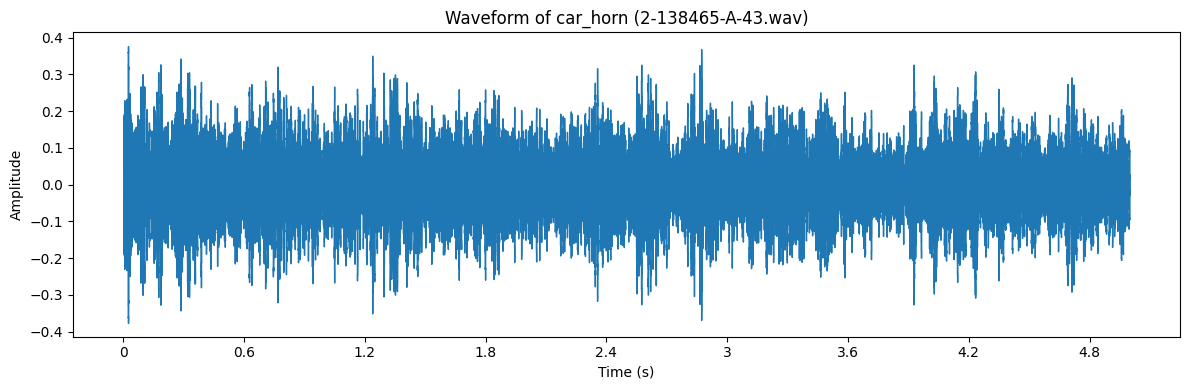

In [ ]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

# Chọn một mẫu ngẫu nhiên từ DataFrame ESC-50
sample_row_esc = metadata_df_esc.sample(1).iloc[0]
sample_audio_path_esc = sample_row_esc['absolute_path']
sample_class_esc = sample_row_esc['category']

print(f"Sample ESC-50 audio file: {sample_audio_path_esc}")
print(f"Class: {sample_class_esc}")

# 1. Tải và phát âm thanh
audio_esc, sr_esc = librosa.load(sample_audio_path_esc, sr=22050)
print(f"Audio loaded. Sample rate: {sr_esc} Hz, Duration: {len(audio_esc)/sr_esc:.2f} seconds")
ipd.display(ipd.Audio(audio_esc, rate=sr_esc))

# 2. Vẽ dạng sóng
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_esc, sr=sr_esc)
plt.title(f'Waveform of {sample_class_esc} ({sample_row_esc["filename"]})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

Sau khi hoàn thành các bước trên, bạn đã có tập dữ liệu ESC-50 được tải xuống, giải nén và tổ chức một cách chính xác trên Google Drive (thông qua symlink vào /content/). File metadata cũng đã được đọc và sẵn sàng để sử dụng. Giờ đây, bạn có thể chuyển sang Bước 3: Trích xuất đặc trưng (DSP - Mel-spectrograms), sử dụng metadata_df_esc và cột absolute_path của nó để duyệt qua các file âm thanh.

#Bước 3: Trích xuất Đặc trưng (DSP - Mel-spectrograms)
Trong bước này, chúng ta sẽ viết mã Python để duyệt qua tất cả các file âm thanh đã chuẩn bị, áp dụng các kỹ thuật Xử lý tín hiệu số (DSP) để trích xuất Mel-spectrogram, chuẩn hóa chúng và lưu trữ để sử dụng trong quá trình huấn luyện mô hình học sâu.

**Mục tiêu của bước này:**
- Đọc từng file âm thanh (.wav).

- Tiền xử lý âm thanh (resampling, padding/trimming).

- Tính toán Mel-spectrogram.

- Chuẩn hóa Mel-spectrogram.

- Lưu trữ Mel-spectrogram đã xử lý cùng với nhãn tương ứng.

**3.1. Các tham số DSP quan trọng**

In [ ]:
import librosa
import librosa.display
import pandas as pd
from tqdm.notebook import tqdm # Để hiển thị thanh tiến độ

# --- Cấu hình DSP ---
SAMPLE_RATE = 22050 # Hz - Tần số lấy mẫu chung cho tất cả audio
N_FFT = 2048        # Kích thước cửa sổ FFT
HOP_LENGTH = 512    # Bước dịch giữa các cửa sổ FFT
N_MELS = 128        # Số lượng Mel bins
DURATION_SEC = 5    # Thời lượng cắt/đệm cho mỗi audio clip (giây)

# Tính toán số khung thời gian tối đa dựa trên các tham số trên
# librosa.feature.melspectrogram sẽ tạo ra (N_MELS, num_frames)
# num_frames = ceil(duration_in_samples / hop_length)
MAX_PAD_LENGTH = int(np.ceil(SAMPLE_RATE * DURATION_SEC / HOP_LENGTH))

print(f"Các tham số DSP:")
print(f"  Sample Rate: {SAMPLE_RATE} Hz")
print(f"  FFT Window Size (N_FFT): {N_FFT} samples")
print(f"  Hop Length: {HOP_LENGTH} samples")
print(f"  Number of Mel Bins (N_MELS): {N_MELS}")
print(f"  Clip Duration: {DURATION_SEC} seconds")
print(f"  Max Spectrogram Frames (MAX_PAD_LENGTH): {MAX_PAD_LENGTH} frames")

# --- Đường dẫn (Đảm bảo khớp với Bước 2.3) ---
# Thư mục gốc UrbanSound8K/ESC-50 đã giải nén
# Nếu bạn dùng UrbanSound8K: URBANSOUND8K_DIR = os.path.join(RAW_DATA_DIR, "UrbanSound8K")
# Nếu bạn dùng ESC-50:
ESC50_EXTRACT_DIR = os.path.join(RAW_DATA_DIR, "ESC-50-master")

ESC50_METADATA_PATH = os.path.join(ESC50_EXTRACT_DIR, "meta", "esc50.csv")
AUDIO_FILES_ROOT = os.path.join(ESC50_EXTRACT_DIR, "audio")

FEATURES_SAVE_DIR = os.path.join(PROJECT_ROOT_DIR_DRIVE, "data", "features", "esc50_mel_specs")
PROCESSED_METADATA_CSV = os.path.join(PROJECT_ROOT_DIR_DRIVE, "data", "features", "esc50_processed_metadata.csv")


# Tạo thư mục lưu đặc trưng nếu chưa có
os.makedirs(FEATURES_SAVE_DIR, exist_ok=True)
print(f"\nFeatures will be saved to: {FEATURES_SAVE_DIR}")
print(f"Processed metadata will be saved to: {PROCESSED_METADATA_CSV}")

Các tham số DSP:
  Sample Rate: 22050 Hz
  FFT Window Size (N_FFT): 2048 samples
  Hop Length: 512 samples
  Number of Mel Bins (N_MELS): 128
  Clip Duration: 5 seconds
  Max Spectrogram Frames (MAX_PAD_LENGTH): 216 frames

Features will be saved to: /content/drive/MyDrive/ESC_Project/data/features/esc50_mel_specs
Processed metadata will be saved to: /content/drive/MyDrive/ESC_Project/data/features/esc50_processed_metadata.csv


**3.2. Viết hàm trích xuất Mel-spectrogram cho một file**

In [ ]:
def extract_mel_spectrogram(audio_path, sample_rate, n_fft, hop_length, n_mels, duration_sec, max_pad_length):
    """
    Trích xuất Mel-spectrogram từ một file audio và chuẩn hóa kích thước.

    Args:
        audio_path (str): Đường dẫn đến file audio.
        sample_rate (int): Tần số lấy mẫu đích.
        n_fft (int): Kích thước cửa sổ FFT.
        hop_length (int): Bước dịch giữa các cửa sổ FFT.
        n_mels (int): Số lượng Mel bins.
        duration_sec (int): Thời lượng (giây) để cắt/đệm audio.
        max_pad_length (int): Số khung thời gian Mel-spectrogram đích.

    Returns:
        np.ndarray: Mel-spectrogram đã được chuẩn hóa kích thước và giá trị.
    """
    try:
        # 1. Đọc tín hiệu âm thanh và resample
        # librosa.load sẽ tự động cắt audio nếu nó dài hơn duration_sec
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration_sec)

        # 2. Đệm (pad) audio nếu nó ngắn hơn duration_sec
        # librosa.load(duration=...) có thể trả về clip ngắn hơn nếu file gốc ngắn
        # Hoặc nếu bạn muốn đảm bảo chính xác 4s
        target_num_samples = sample_rate * duration_sec
        if len(audio) < target_num_samples:
            padding = target_num_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # 3. Trích xuất Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        # Chuyển đổi sang thang đo decibel (dB)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # 4. Chuẩn hóa kích thước của Mel-spectrogram (Pad/Trimm)
        # CNN yêu cầu tất cả input có cùng kích thước
        if mel_spectrogram_db.shape[1] > max_pad_length:
            mel_spectrogram_db = mel_spectrogram_db[:, :max_pad_length]
        elif mel_spectrogram_db.shape[1] < max_pad_length:
            pad_width = max_pad_length - mel_spectrogram_db.shape[1]
            mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

        # 5. Chuẩn hóa giá trị (Standardization)
        # standardization toàn cục trên toàn bộ tập dữ liệu thường tốt hơn
        # nhưng ở đây ta làm trên từng spectrogram để đơn giản.
        # Trong quá trình huấn luyện, bạn có thể tính mean/std của toàn bộ tập huấn luyện.
        mean_val = mel_spectrogram_db.mean()
        std_val = mel_spectrogram_db.std()
        # Thêm 1e-6 vào mẫu số để tránh chia cho 0 nếu std = 0 (trường hợp hiếm)
        mel_spectrogram_db = (mel_spectrogram_db - mean_val) / (std_val + 1e-6)

        return mel_spectrogram_db

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

**3.3. Duyệt qua tập dữ liệu và trích xuất đặc trưng**

In [ ]:
# 1. Tải metadata ESC-50 đã chuẩn bị ở Bước 2.5
# Đảm bảo ESC50_METADATA_PATH và AUDIO_FILES_ROOT đã được định nghĩa
# ở các cell trước hoặc copy lại ở đây
metadata_df_esc = pd.read_csv(ESC50_METADATA_PATH)
metadata_df_esc['absolute_path'] = metadata_df_esc.apply(
    lambda row: os.path.join(AUDIO_FILES_ROOT, row['filename']),
    axis=1
)

# Danh sách để lưu thông tin về các đặc trưng đã xử lý
processed_features_data = []

print(f"Starting Mel-spectrogram extraction for {len(metadata_df_esc)} audio files...")

# 2. Duyệt qua từng file audio và trích xuất đặc trưng
# tqdm.iterrows() giúp hiển thị thanh tiến độ đẹp mắt
for index, row in tqdm(metadata_df_esc.iterrows(), total=len(metadata_df_esc), desc="Processing audio files"):
    audio_file_path = row['absolute_path']
    class_name = row['category']
    class_id = row['target'] # ID số của lớp trong ESC-50

    # Trích xuất Mel-spectrogram
    mel_spec = extract_mel_spectrogram(
        audio_file_path,
        SAMPLE_RATE,
        N_FFT,
        HOP_LENGTH,
        N_MELS,
        DURATION_SEC,
        MAX_PAD_LENGTH
    )

    if mel_spec is not None:
        # Tạo tên file độc đáo để lưu đặc trưng
        # Sử dụng hash hoặc index + filename để đảm bảo tính duy nhất
        feature_filename = f"mel_spec_{index}_{os.path.basename(audio_file_path).replace('.wav', '')}.npy"
        feature_save_path = os.path.join(FEATURES_SAVE_DIR, feature_filename)

        # Lưu Mel-spectrogram dưới dạng file NumPy (.npy)
        np.save(feature_save_path, mel_spec)

        processed_features_data.append({
            'feature_path': feature_save_path,
            'class_name': class_name,
            'class_id': class_id,
            'original_filename': row['filename']
        })

# 3. Lưu thông tin về các đặc trưng đã xử lý vào một file CSV mới
processed_df_final = pd.DataFrame(processed_features_data)
processed_df_final.to_csv(PROCESSED_METADATA_CSV, index=False)

print(f"\nFeature extraction complete. Saved {len(processed_df_final)} features.")
print(f"Processed metadata saved to: {PROCESSED_METADATA_CSV}")

# Kiểm tra một vài file đặc trưng đã được lưu
!ls -F "{FEATURES_SAVE_DIR}" | head -n 5

Starting Mel-spectrogram extraction for 2000 audio files...


Processing audio files:   0%|          | 0/2000 [00:00<?, ?it/s]


Feature extraction complete. Saved 2000 features.
Processed metadata saved to: /content/drive/MyDrive/ESC_Project/data/features/esc50_processed_metadata.csv
mel_spec_0_1-100032-A-0.npy
mel_spec_1000_3-151212-A-24.npy
mel_spec_100_1-208757-B-2.npy
mel_spec_1001_3-151213-A-24.npy
mel_spec_1002_3-151255-A-28.npy


**3.4. Trực quan hóa một ví dụ Mel-spectrogram**


Example Mel-spectrogram shape: (128, 216)
Example Mel-spectrogram values (min, max): -0.24, 7.52


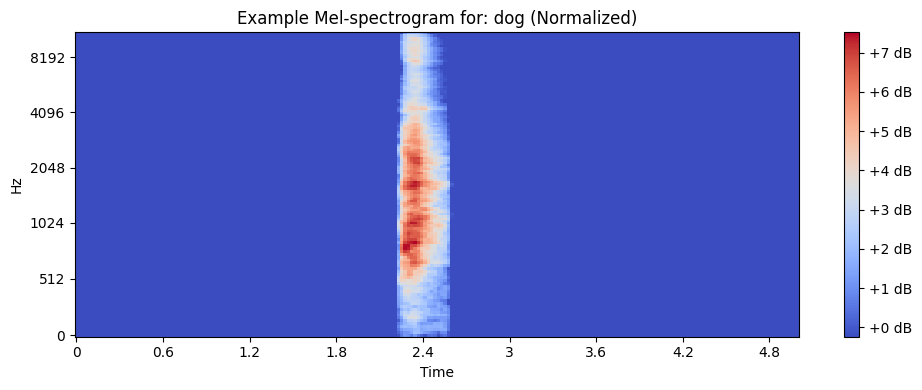

In [ ]:
import librosa.display # Đảm bảo đã import ở đầu cell nếu bạn chạy độc lập

if not processed_df_final.empty:
    # Lấy đường dẫn của spectrogram đầu tiên đã xử lý
    example_feature_path = processed_df_final['feature_path'].iloc[0]
    example_class_name = processed_df_final['class_name'].iloc[0]

    # Tải spectrogram
    example_mel_spec = np.load(example_feature_path)

    print(f"\nExample Mel-spectrogram shape: {example_mel_spec.shape}")
    print(f"Example Mel-spectrogram values (min, max): {example_mel_spec.min():.2f}, {example_mel_spec.max():.2f}")

    # Vẽ spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(example_mel_spec, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB') # Spectrogram đang ở thang dB, nhưng giá trị đã chuẩn hóa
    plt.title(f'Example Mel-spectrogram for: {example_class_name} (Normalized)')
    plt.tight_layout()
    plt.show()
else:
    print("No features were processed. Cannot display example spectrogram.")

Sau khi hoàn thành Bước 3, ta đã thành công trong việc:

Định nghĩa các tham số DSP cần thiết.

Viết mã để đọc các file âm thanh thô.

Áp dụng các kỹ thuật DSP (resampling, padding/trimming, Mel-spectrogram calculation).

Chuẩn hóa các đặc trưng.
Lưu trữ các Mel-spectrogram đã xử lý dưới dạng file .npy và cập nhật file metadata CSV.

Giờ đây, ta có một tập dữ liệu các đặc trưng số đã được chuẩn bị sẵn sàng để đưa vào mô hình học sâu (CNN) ở bước tiếp theo!

# Bước 4: Thiết lập và Huấn luyện Mô hình AI (CNN)
Trong bước này, chúng ta sẽ:

- Tải dữ liệu đặc trưng (Mel-spectrograms) đã được trích xuất và chuẩn hóa ở Bước 3.

- Chia tập dữ liệu thành các tập huấn luyện (training), kiểm định (validation) và kiểm thử (test).

- Định nghĩa kiến trúc mạng nơ-ron tích chập (CNN) sử dụng PyTorch.

- Cấu hình quá trình huấn luyện (hàm mất mát, bộ tối ưu hóa).

- Thực hiện vòng lặp huấn luyện mô hình.

- Lưu mô hình đã được huấn luyện.

**4.1. Tải và Chuẩn bị Dữ liệu cho PyTorch**

Trước khi huấn luyện, chúng ta cần load các đường dẫn đến file đặc trưng và nhãn từ file `processed_metadata`.csv và sau đó load các file `.npy` vào bộ nhớ. Để quản lý dữ liệu hiệu quả với PyTorch, chúng ta sẽ sử dụng `Dataset` và `DataLoader`

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random # Để đảm bảo tính tái lập (reproducibility)

# --- Cấu hình chung (đảm bảo khớp với các bước trước) ---
# Lấy từ Bước 1:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PROJECT_ROOT_DIR_DRIVE = "/content/drive/MyDrive/ESC_Project"

# Lấy từ Bước 3:
# FEATURES_SAVE_DIR = os.path.join(PROJECT_ROOT_DIR_DRIVE, "data", "features", "esc50_mel_specs")
# PROCESSED_METADATA_CSV = os.path.join(PROJECT_ROOT_DIR_DRIVE, "data", "features", "esc50_processed_metadata.csv")
# MAX_PAD_LENGTH = ... (đã tính ở bước 3)
# N_MELS = ... (đã định nghĩa ở bước 3)

# --- Cấu hình huấn luyện ---
BATCH_SIZE = 64        # Kích thước lô (batch size)
NUM_EPOCHS = 30        # Số lượng epoch (số lần lặp qua toàn bộ tập huấn luyện)
LEARNING_RATE = 0.001  # Tốc độ học của thuật toán tối ưu hóa

# --- Cấu hình cho việc tái lập kết quả (Reproducibility) ---
# Đặt seed để các lần chạy (với cùng mã và dữ liệu) cho ra kết quả giống nhau
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED) # For all GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Tắt tính năng tự động tối ưu của cuDNN

print(f"Using device: {device}")

# 1. Tải metadata đã xử lý từ file CSV
processed_df = pd.read_csv(PROCESSED_METADATA_CSV)
print(f"Loaded {len(processed_df)} processed features paths.")

# 2. Chuẩn bị nhãn: Chuyển đổi nhãn chữ (category) thành nhãn số (class ID)
le = LabelEncoder()
processed_df['class_id_encoded'] = le.fit_transform(processed_df['class_name'])
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {list(zip(le.classes_, le.transform(le.classes_)))}")


# 3. Định nghĩa PyTorch Dataset tùy chỉnh
class AudioDataset(Dataset):
    def __init__(self, metadata_df, max_pad_length, n_mels):
        self.metadata = metadata_df
        self.max_pad_length = max_pad_length
        self.n_mels = n_mels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Tải Mel-spectrogram từ file .npy
        feature_path = self.metadata.iloc[idx]['feature_path']
        mel_spec = np.load(feature_path)

        # Đảm bảo kích thước cuối cùng là (1, N_MELS, MAX_PAD_LENGTH)
        # CNN PyTorch mong đợi (batch_size, channels, height, width)
        # Spectrogram đã được chuẩn hóa kích thước (N_MELS, MAX_PAD_LENGTH) ở Bước 3
        # Chỉ cần thêm chiều kênh (channel dimension)
        mel_spec = mel_spec[np.newaxis, :, :] # Giờ là (1, N_MELS, MAX_PAD_LENGTH)

        # Chuyển đổi sang Tensor và kiểu float32
        mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32)

        # Lấy nhãn
        label = torch.tensor(self.metadata.iloc[idx]['class_id_encoded'], dtype=torch.long)

        return mel_spec_tensor, label

# 4. Chia tập dữ liệu thành huấn luyện (train), kiểm định (validation) và kiểm thử (test)
# train_test_split sẽ chia DataFrame metadata_df, sau đó Dataset sẽ dùng DataFrame này để load feature
train_val_df, test_df = train_test_split(processed_df, test_size=0.1, random_state=SEED, stratify=processed_df['class_id_encoded'])
train_df, val_df = train_test_split(train_val_df, test_size=0.15/0.9, random_state=SEED, stratify=train_val_df['class_id_encoded'])

print(f"\nTrain samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# 5. Tạo các đối tượng Dataset và DataLoader
train_dataset = AudioDataset(train_df, MAX_PAD_LENGTH, N_MELS)
val_dataset = AudioDataset(val_df, MAX_PAD_LENGTH, N_MELS)
test_dataset = AudioDataset(test_df, MAX_PAD_LENGTH, N_MELS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers để load dữ liệu song song
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("\nDataLoaders created successfully.")
# Kiểm tra kích thước một batch đầu tiên
for batch_features, batch_labels in train_loader:
    print(f"Shape of one batch of features: {batch_features.shape}") # Expected: (BATCH_SIZE, 1, N_MELS, MAX_PAD_LENGTH)
    print(f"Shape of one batch of labels: {batch_labels.shape}")   # Expected: (BATCH_SIZE)
    break

Using device: cuda
Loaded 2000 processed features paths.
Number of classes: 50
Class mapping: [('airplane', np.int64(0)), ('breathing', np.int64(1)), ('brushing_teeth', np.int64(2)), ('can_opening', np.int64(3)), ('car_horn', np.int64(4)), ('cat', np.int64(5)), ('chainsaw', np.int64(6)), ('chirping_birds', np.int64(7)), ('church_bells', np.int64(8)), ('clapping', np.int64(9)), ('clock_alarm', np.int64(10)), ('clock_tick', np.int64(11)), ('coughing', np.int64(12)), ('cow', np.int64(13)), ('crackling_fire', np.int64(14)), ('crickets', np.int64(15)), ('crow', np.int64(16)), ('crying_baby', np.int64(17)), ('dog', np.int64(18)), ('door_wood_creaks', np.int64(19)), ('door_wood_knock', np.int64(20)), ('drinking_sipping', np.int64(21)), ('engine', np.int64(22)), ('fireworks', np.int64(23)), ('footsteps', np.int64(24)), ('frog', np.int64(25)), ('glass_breaking', np.int64(26)), ('hand_saw', np.int64(27)), ('helicopter', np.int64(28)), ('hen', np.int64(29)), ('insects', np.int64(30)), ('keyboard_

**4.2. Định nghĩa Kiến trúc Mạng CNN**

Bước này ta sẽ định nghĩa lớp `AudioCNN` kế thừa từ `torch.nn.Module.`

In [ ]:
# 6. Định nghĩa kiến trúc CNN
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()

        # Lớp Convolutional đầu tiên
        # Input: (batch_size, 1, N_MELS, MAX_PAD_LENGTH)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(32) # Batch Normalization
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) # Pooling (giảm kích thước)
        self.dropout1 = nn.Dropout(0.25) # Dropout (chống overfitting)

        # Lớp Convolutional thứ hai
        # Input: (batch_size, 32, N_MELS/2, MAX_PAD_LENGTH/2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout2 = nn.Dropout(0.25)

        # Lớp Convolutional thứ ba (thêm 1 lớp để tăng chiều sâu)
        # Input: (batch_size, 64, N_MELS/4, MAX_PAD_LENGTH/4)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout3 = nn.Dropout(0.25)

        # Tính toán kích thước đầu vào cho lớp Linear (Flatten)
        # Cách tốt nhất là chạy một forward pass với input dummy
        # Giả định input ban đầu: (1, 1, N_MELS, MAX_PAD_LENGTH)
        dummy_input = torch.zeros(1, 1, N_MELS, MAX_PAD_LENGTH)
        x = self.pool1(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        self._to_linear = x.flatten(1).shape[1] # Kích thước đầu ra của Flatten (số features)

        # Các lớp Fully Connected (Linear)
        self.fc1 = nn.Linear(self._to_linear, 256) # Lớp ẩn đầu tiên
        self.dropout4 = nn.Dropout(0.5) # Dropout trước lớp cuối
        self.fc2 = nn.Linear(256, num_classes) # Lớp đầu ra (số nơ-ron bằng số lớp)

    def forward(self, x):
        # Quy trình: Conv -> BatchNorm -> ReLU -> Pool -> Dropout
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))

        x = x.flatten(1) # Flatten ngoại trừ batch dimension (giữ nguyên batch_size)

        x = self.dropout4(F.relu(self.fc1(x)))
        x = self.fc2(x) # Lớp đầu ra cuối cùng, không áp dụng softmax ở đây vì CrossEntropyLoss sẽ tự làm
        return x

# Khởi tạo mô hình và chuyển nó lên GPU
model = AudioCNN(num_classes).to(device)
print("Model Architecture:")
print(model)

# 7. Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.CrossEntropyLoss() # Hàm mất mát cho phân loại đa lớp
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Bộ tối ưu hóa Adam

print("\nModel, Loss Function, and Optimizer defined.")

Model Architecture:
AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=55296, out_features=256, b

**4.3. Huấn luyện Mô hình**

In [ ]:
# 8. Huấn luyện mô hình
print("\nStarting training...")
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    # --- Chế độ huấn luyện (training mode) ---
    model.train() # Bật chế độ huấn luyện (cho Batch Norm và Dropout)
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Duyệt qua các batch trong train_loader
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Training)")):
        inputs, labels = inputs.to(device), labels.to(device) # Chuyển dữ liệu lên GPU

        optimizer.zero_grad() # Đặt tất cả các gradient về 0 cho mỗi batch

        outputs = model(inputs) # Forward pass: lấy dự đoán từ mô hình
        loss = criterion(outputs, labels) # Tính toán hàm mất mát

        loss.backward() # Backward pass: tính toán gradient của mất mát so với các tham số
        optimizer.step() # Cập nhật trọng số của mô hình dựa trên gradient

        running_loss += loss.item() * inputs.size(0) # Tích lũy mất mát
        _, predicted = torch.max(outputs.data, 1) # Lấy dự đoán lớp có xác suất cao nhất
        total_train += labels.size(0) # Tổng số mẫu trong batch
        correct_train += (predicted == labels).sum().item() # Số mẫu được dự đoán đúng

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train / total_train
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # --- Chế độ đánh giá (evaluation mode) trên tập kiểm định ---
    model.eval() # Bật chế độ đánh giá (tắt Dropout, Batch Norm dùng mean/std của tập huấn luyện)
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # Không tính gradient trong chế độ đánh giá để tiết kiệm bộ nhớ và tăng tốc
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Validation)"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / total_val
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

print("\nTraining complete!")

# 9. Lưu mô hình (chỉ lưu state_dict - các trọng số đã học)
MODEL_SAVE_PATH = os.path.join(MODELS_SAVE_DIR, "audio_cnn_model.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")


Starting training...


Epoch 1/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 9.2356, Train Acc: 0.0267, Val Loss: 3.8508, Val Acc: 0.0500


Epoch 2/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 3.8786, Train Acc: 0.0407, Val Loss: 3.8230, Val Acc: 0.0567


Epoch 3/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 3.8377, Train Acc: 0.0413, Val Loss: 3.7643, Val Acc: 0.0700


Epoch 4/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 3.8010, Train Acc: 0.0413, Val Loss: 3.7413, Val Acc: 0.0800


Epoch 5/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 3.7539, Train Acc: 0.0453, Val Loss: 3.7110, Val Acc: 0.0667


Epoch 6/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 3.7432, Train Acc: 0.0573, Val Loss: 3.7092, Val Acc: 0.0733


Epoch 7/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 3.6989, Train Acc: 0.0507, Val Loss: 3.6075, Val Acc: 0.0733


Epoch 8/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 3.6606, Train Acc: 0.0527, Val Loss: 3.5677, Val Acc: 0.1067


Epoch 9/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 3.6662, Train Acc: 0.0553, Val Loss: 3.5338, Val Acc: 0.0933


Epoch 10/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 3.6380, Train Acc: 0.0587, Val Loss: 3.4470, Val Acc: 0.0967


Epoch 11/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 3.5780, Train Acc: 0.0693, Val Loss: 3.4456, Val Acc: 0.0967


Epoch 12/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 3.5510, Train Acc: 0.0773, Val Loss: 3.3996, Val Acc: 0.1067


Epoch 13/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 3.5711, Train Acc: 0.0733, Val Loss: 3.3218, Val Acc: 0.1267


Epoch 14/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 3.4681, Train Acc: 0.0907, Val Loss: 3.2397, Val Acc: 0.1267


Epoch 15/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 3.4418, Train Acc: 0.0853, Val Loss: 3.2502, Val Acc: 0.1400


Epoch 16/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 3.4961, Train Acc: 0.0820, Val Loss: 3.2833, Val Acc: 0.1167


Epoch 17/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 3.4467, Train Acc: 0.0780, Val Loss: 3.2045, Val Acc: 0.1367


Epoch 18/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/30], Train Loss: 3.4284, Train Acc: 0.0967, Val Loss: 3.2183, Val Acc: 0.1467


Epoch 19/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/30], Train Loss: 3.3682, Train Acc: 0.0973, Val Loss: 3.1879, Val Acc: 0.1667


Epoch 20/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/30], Train Loss: 3.4110, Train Acc: 0.0860, Val Loss: 3.1375, Val Acc: 0.1467


Epoch 21/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21/30], Train Loss: 3.3615, Train Acc: 0.0960, Val Loss: 3.2071, Val Acc: 0.1800


Epoch 22/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22/30], Train Loss: 3.3297, Train Acc: 0.1027, Val Loss: 3.1055, Val Acc: 0.1533


Epoch 23/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23/30], Train Loss: 3.3447, Train Acc: 0.0993, Val Loss: 3.0258, Val Acc: 0.1833


Epoch 24/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24/30], Train Loss: 3.3045, Train Acc: 0.1147, Val Loss: 2.9972, Val Acc: 0.1933


Epoch 25/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25/30], Train Loss: 3.2870, Train Acc: 0.1033, Val Loss: 3.0230, Val Acc: 0.2100


Epoch 26/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26/30], Train Loss: 3.2704, Train Acc: 0.1127, Val Loss: 3.1001, Val Acc: 0.1833


Epoch 27/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27/30], Train Loss: 3.3134, Train Acc: 0.1093, Val Loss: 2.9611, Val Acc: 0.2133


Epoch 28/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28/30], Train Loss: 3.2033, Train Acc: 0.1167, Val Loss: 3.0084, Val Acc: 0.2000


Epoch 29/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [29/30], Train Loss: 3.2369, Train Acc: 0.1053, Val Loss: 2.9943, Val Acc: 0.2433


Epoch 30/30 (Training):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30/30 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [30/30], Train Loss: 3.1990, Train Acc: 0.1253, Val Loss: 3.0266, Val Acc: 0.1867

Training complete!
Model saved to: /content/drive/MyDrive/ESC_Project/models/audio_cnn_model.pth


**4.4. Trực quan hóa quá trình huấn luyện**

Để đánh giá hiệu suất của mô hình qua các epoch và phát hiện các vấn đề như overfitting, chúng ta sẽ vẽ đồ thị loss và accuracy.

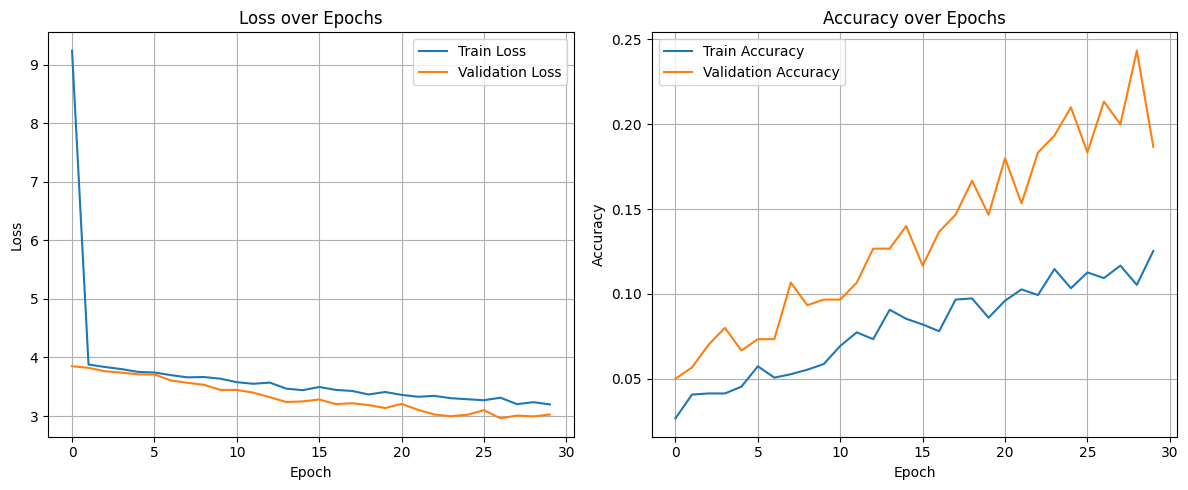

In [ ]:
# 10. Trực quan hóa quá trình huấn luyện
plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# (Tùy chọn) Lưu biểu đồ
# plt.savefig(os.path.join(PROJECT_ROOT_DIR_DRIVE, "training_history.png"))
# print(f"Training history plot saved to: {os.path.join(PROJECT_ROOT_DIR_DRIVE, 'training_history.png')}")

Sau khi hoàn thành Bước 4, bạn đã có một mô hình CNN được huấn luyện, lưu trữ các trọng số của nó trên Google Drive. Bạn cũng có thể theo dõi quá trình học tập của mô hình thông qua các biểu đồ loss và accuracy.

# Bước 5: Đánh giá Mô hình
Mục tiêu của bước này:

- Tải mô hình đã huấn luyện.

- Thực hiện dự đoán trên toàn bộ tập kiểm thử.

- Tính toán các chỉ số hiệu suất quan trọng (độ chính xác, precision, recall, F1-score).

- Trực quan hóa ma trận nhầm lẫn (Confusion Matrix).


5.1. Tải Mô hình và Chuẩn bị Đánh giá

Đảm bảo rằng các biến toàn cục như device, MODEL_SAVE_PATH, num_classes, le (LabelEncoder), và test_loader đã được định nghĩa và có giá trị từ các bước trước đó. Nếu bạn đang chạy các cell riêng lẻ, hãy đảm bảo rằng các cell của Bước 1 và Bước 4 (ít nhất là phần định nghĩa mô hình AudioCNN và MODEL_SAVE_PATH, le, num_classes, test_loader) đã được chạy.

Model loaded and set to evaluation mode.

Evaluating model on test set...


Testing model:   0%|          | 0/4 [00:00<?, ?it/s]


Test Accuracy: 0.1750

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00         4
       breathing       0.00      0.00      0.00         4
  brushing_teeth       0.00      0.00      0.00         4
     can_opening       0.00      0.00      0.00         4
        car_horn       0.00      0.00      0.00         4
             cat       0.00      0.00      0.00         4
        chainsaw       0.00      0.00      0.00         4
  chirping_birds       0.17      0.25      0.20         4
    church_bells       0.17      0.75      0.27         4
        clapping       0.00      0.00      0.00         4
     clock_alarm       0.67      1.00      0.80         4
      clock_tick       0.00      0.00      0.00         4
        coughing       0.00      0.00      0.00         4
             cow       0.00      0.00      0.00         4
  crackling_fire       0.00      0.00      0.00         4
        crickets       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


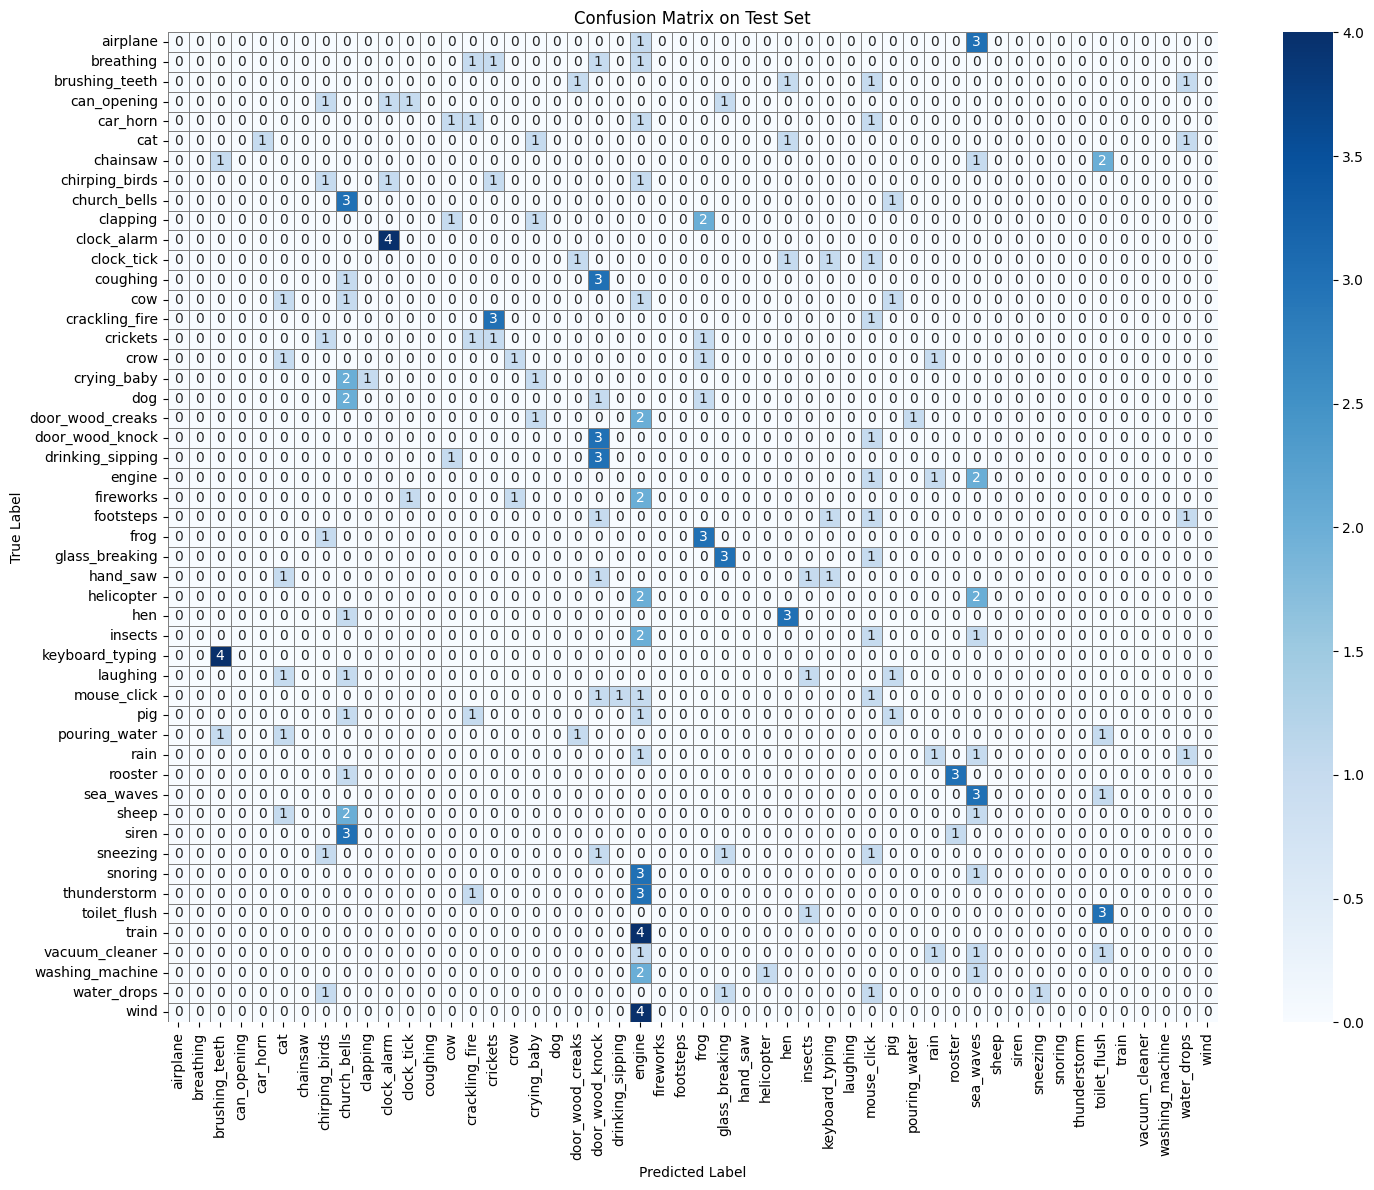

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Tải mô hình đã huấn luyện ---
# Khởi tạo lại kiến trúc mô hình với các tham số tương tự như lúc huấn luyện
# Đảm bảo class AudioCNN đã được định nghĩa ở Bước 4
model = AudioCNN(num_classes).to(device)

# Tải trọng số đã học từ file .pth
# map_location=device đảm bảo model được tải về đúng thiết bị (GPU hoặc CPU)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))

# Đặt mô hình ở chế độ đánh giá (evaluation mode)
# Điều này rất quan trọng: nó sẽ tắt các lớp như Dropout và đặt BatchNorm
# sử dụng các thống kê (mean, variance) từ tập huấn luyện thay vì thống kê của batch hiện tại.
model.eval()

print("Model loaded and set to evaluation mode.")

# --- 2. Thực hiện dự đoán trên tập kiểm thử ---
print("\nEvaluating model on test set...")

correct_test = 0      # Số mẫu được phân loại đúng
total_test = 0        # Tổng số mẫu trong tập kiểm thử
all_preds = []        # Danh sách lưu trữ tất cả các dự đoán của mô hình
all_labels = []       # Danh sách lưu trữ tất cả các nhãn thực tế

# Sử dụng torch.no_grad() để không tính toán và lưu trữ gradient trong quá trình đánh giá
# Điều này giúp tiết kiệm bộ nhớ và tăng tốc độ tính toán
with torch.no_grad():
    # Duyệt qua từng batch trong test_loader
    for inputs, labels in tqdm(test_loader, desc="Testing model"):
        inputs, labels = inputs.to(device), labels.to(device) # Chuyển dữ liệu lên GPU (nếu có)

        outputs = model(inputs) # Thực hiện forward pass để lấy dự đoán của mô hình

        # Lấy lớp được dự đoán có xác suất cao nhất
        # outputs.data chứa các logits (giá trị trước softmax)
        # torch.max(outputs.data, 1) trả về (max_value, argmax_index) theo chiều 1 (lớp)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0) # Cộng dồn tổng số mẫu
        correct_test += (predicted == labels).sum().item() # Cộng dồn số mẫu được dự đoán đúng

        # Lưu trữ dự đoán và nhãn thực tế vào danh sách
        # .cpu().numpy() để chuyển Tensor về CPU và sau đó thành mảng NumPy
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 3. Tính toán và in các chỉ số hiệu suất tổng thể ---
test_accuracy = correct_test / total_test
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# --- 4. In báo cáo phân loại chi tiết (Precision, Recall, F1-score) ---
# classification_report cung cấp các chỉ số này cho từng lớp và tổng thể
# target_names: tên các lớp (từ LabelEncoder) để báo cáo dễ đọc hơn
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# --- 5. Vẽ ma trận nhầm lẫn (Confusion Matrix) ---
# confusion_matrix tính toán ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)

# Sử dụng seaborn để vẽ heatmap của ma trận nhầm lẫn
plt.figure(figsize=(15, 12)) # Kích thước lớn hơn cho 50 lớp để dễ nhìn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=.5, linecolor='gray', cbar=True)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# (Tùy chọn) Lưu ma trận nhầm lẫn vào Drive
# plt.savefig(os.path.join(PROJECT_ROOT_DIR_DRIVE, "confusion_matrix.png"))
# print(f"Confusion Matrix saved to: {os.path.join(PROJECT_ROOT_DIR_DRIVE, 'confusion_matrix.png')}")

# Bước 6: Dự đoán trên File Âm thanh Mới
Trong bước này, chúng ta sẽ:

- Chọn một file âm thanh mới để thử nghiệm (có thể là một file từ tập dữ liệu nhưng không nằm trong tập huấn luyện/kiểm định/kiểm thử, hoặc một file hoàn toàn mới được bạn tự thu âm/tải lên).

- Áp dụng CHÍNH XÁC quy trình tiền xử lý DSP (tính Mel-spectrogram và chuẩn hóa) mà chúng ta đã sử dụng trong các bước trước.

- Tải mô hình CNN đã huấn luyện.

- Thực hiện dự đoán và hiển thị kết quả.

- Trực quan hóa Mel-spectrogram của file âm thanh mới.

**Mục tiêu của bước này:**

- Kiểm tra khả năng hoạt động của mô hình trên dữ liệu thực tế.

- Hiểu cách chuẩn bị dữ liệu mới cho mô hình.

- Xác nhận mô hình có thể tải và sử dụng được.

**6.1. Chuẩn bị File Âm thanh Mới và Các Hàm Cần Thiết**

Đảm bảo rằng các biến toàn cục như `device`, `N_MELS`, `MAX_PAD_LENGTH`, `SAMPLE_RATE`, `N_FFT`, `HOP_LENGTH`, `DURATION_SEC`, `MODEL_SAVE_PATH`, `num_classes`, `le `(LabelEncoder) đã được định nghĩa và có giá trị từ các bước trước đó.

Bạn sẽ cần một đường dẫn đến một file âm thanh .wav. Có thể chọn một file từ tập dữ liệu ESC-50 đã giải nén (nhưng tốt nhất là từ test_df hoặc một file khác bạn tự tải lên).

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd # Để phát audio

# --- Các biến từ các bước trước (đảm bảo đã được định nghĩa) ---
# device (từ Bước 1)
# N_MELS, MAX_PAD_LENGTH, SAMPLE_RATE, N_FFT, HOP_LENGTH, DURATION_SEC (từ Bước 3)
# MODEL_SAVE_PATH (từ Bước 4)
# num_classes, le (LabelEncoder) (từ Bước 4)

# --- 6.1.1 Chọn đường dẫn tới file âm thanh mới để dự đoán ---
# Option 1: Chọn một file từ tập dữ liệu ESC-50 đã giải nén (ví dụ, một file từ test set)
# Bạn có thể tự tìm một file từ `test_df['absolute_path']`
# Hoặc đơn giản là lấy một file bất kỳ để thử
#NEW_AUDIO_PATH = os.path.join(ESC50_EXTRACT_DIR, "audio", "4-169822-A-30.wav") # Ví dụ: "can_opening"

NEW_AUDIO_PATH = metadata_df_esc['absolute_path'].iloc[0]
print(f"Using test file from metadata: {NEW_AUDIO_PATH}")
# Hoặc: NEW_AUDIO_PATH = "/content/drive/MyDrive/ESC_Project/your_new_audio_file.wav"
#      (Nếu bạn tự upload một file WAV mới vào Drive)

print(f"File âm thanh mới để dự đoán: {NEW_AUDIO_PATH}")


# --- 6.1.2 Định nghĩa lại hàm tiền xử lý cho audio mới (đảm bảo khớp với lúc huấn luyện) ---
# Hàm này giống hệt hàm extract_mel_spectrogram nhưng chỉ xử lý một file và trả về tensor sẵn sàng cho mô hình
def preprocess_new_audio_for_inference(audio_path, sample_rate, n_fft, hop_length, n_mels, duration_sec, max_pad_length):
    """
    Tiền xử lý một file audio duy nhất để chuẩn bị cho inference.
    Thực hiện các bước DSP tương tự như trong quá trình trích xuất đặc trưng.
    """
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration_sec)

        target_num_samples = sample_rate * duration_sec
        if len(audio) < target_num_samples:
            padding = target_num_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        if mel_spectrogram_db.shape[1] > max_pad_length:
            mel_spectrogram_db = mel_spectrogram_db[:, :max_pad_length]
        elif mel_spectrogram_db.shape[1] < max_pad_length:
            pad_width = max_pad_length - mel_spectrogram_db.shape[1]
            mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

        # Chuẩn hóa giá trị (Standardization) - sử dụng lại logic từ hàm extract_mel_spectrogram
        # QUAN TRỌNG: Để chính xác, bạn nên dùng mean/std của TOÀN BỘ tập huấn luyện.
        # Ở đây, ta dùng mean/std của chính spectrogram này cho đơn giản,
        # nhưng có thể dẫn đến sai số nhỏ nếu phân bố của spectrogram này khác với phân bố chung.
        mean_val = mel_spectrogram_db.mean()
        std_val = mel_spectrogram_db.std()
        mel_spectrogram_db = (mel_spectrogram_db - mean_val) / (std_val + 1e-6)

        # Thêm các chiều cần thiết cho PyTorch CNN: (batch_size=1, channels=1, N_MELS, MAX_PAD_LENGTH)
        return mel_spectrogram_db[np.newaxis, np.newaxis, :, :]

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# --- 6.1.3 Tải mô hình đã huấn luyện (đảm bảo kiến trúc AudioCNN đã được định nghĩa ở Bước 4) ---
# model_inference = AudioCNN(num_classes).to(device) # Khởi tạo lại kiến trúc
# model_inference.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device)) # Tải trọng số
# model_inference.eval() # Đặt mô hình ở chế độ đánh giá

# print("Model loaded and ready for inference.")

Using test file from metadata: /content/drive/MyDrive/ESC_Project/data/raw/ESC-50-master/audio/1-100032-A-0.wav
File âm thanh mới để dự đoán: /content/drive/MyDrive/ESC_Project/data/raw/ESC-50-master/audio/1-100032-A-0.wav


**6.2. Thực hiện Dự đoán**

Playing audio: 1-100032-A-0.wav



Preprocessing new audio file: 1-100032-A-0.wav
Model loaded and set to evaluation mode for inference.

Performing prediction...

--- Prediction Result for '1-100032-A-0.wav' ---
Predicted class ID: 20
Predicted class name: door_wood_knock
Probabilities for all classes: [0.02056948 0.02051163 0.01791122 0.01743935 0.02252145 0.02142819
 0.02191776 0.01913379 0.01937148 0.01867894 0.01560862 0.02075083
 0.0241848  0.02243158 0.01739116 0.01544724 0.01789892 0.01877065
 0.02111192 0.01978764 0.0243896  0.02381259 0.02057592 0.02172451
 0.02171554 0.0155774  0.01827621 0.02074653 0.01813338 0.01751124
 0.02303758 0.01893668 0.01836681 0.02062913 0.02370748 0.01833301
 0.01915755 0.01719255 0.02067898 0.02080642 0.01677328 0.02002808
 0.02107968 0.02151634 0.02026442 0.02078441 0.02279237 0.01974076
 0.0215673  0.01927754]

Top 3 predicted classes:
  door_wood_knock: 0.0244
  coughing: 0.0242
  drinking_sipping: 0.0238


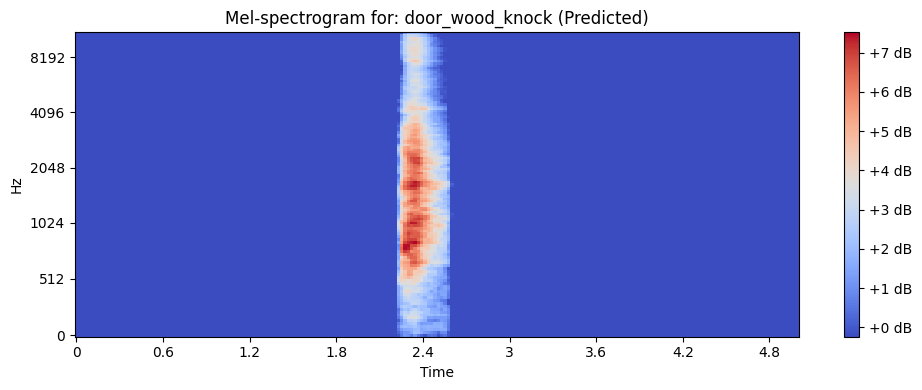

In [ ]:
# --- 6.2.1 Phát âm thanh mới (tùy chọn) ---
try:
    print(f"Playing audio: {os.path.basename(NEW_AUDIO_PATH)}")
    audio_for_play, sr_for_play = librosa.load(NEW_AUDIO_PATH, sr=SAMPLE_RATE)
    ipd.display(ipd.Audio(audio_for_play, rate=sr_for_play))
except Exception as e:
    print(f"Could not play audio: {e}")

# --- 6.2.2 Tiền xử lý file âm thanh mới ---
print(f"\nPreprocessing new audio file: {os.path.basename(NEW_AUDIO_PATH)}")
new_spec_processed = preprocess_new_audio_for_inference(
    NEW_AUDIO_PATH, SAMPLE_RATE, N_FFT, HOP_LENGTH, N_MELS, DURATION_SEC, MAX_PAD_LENGTH
)

if new_spec_processed is None:
    print("Failed to preprocess new audio. Exiting inference.")
else:
    # Chuyển mảng NumPy đã xử lý thành PyTorch Tensor và đưa lên thiết bị (GPU/CPU)
    new_spec_tensor = torch.tensor(new_spec_processed, dtype=torch.float32).to(device)

    # --- 6.2.3 Tải mô hình đã huấn luyện (nếu chưa tải) ---
    # Nếu bạn đã chạy cell 6.1.3, không cần chạy lại
    # Khởi tạo lại kiến trúc mô hình với các tham số tương tự như lúc huấn luyện
    model_inference = AudioCNN(num_classes).to(device)
    # Tải trọng số đã học từ file .pth
    model_inference.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    # Đặt mô hình ở chế độ đánh giá
    model_inference.eval()
    print("Model loaded and set to evaluation mode for inference.")


    # --- 6.2.4 Thực hiện dự đoán ---
    print("\nPerforming prediction...")
    with torch.no_grad(): # Không tính gradient trong quá trình dự đoán
        output = model_inference(new_spec_tensor) # Forward pass
        probabilities = F.softmax(output, dim=1) # Chuyển logits sang xác suất

        predicted_class_id = torch.argmax(probabilities, dim=1).item() # Lấy ID lớp có xác suất cao nhất
        predicted_class_name = le.inverse_transform([predicted_class_id])[0] # Chuyển ID số thành tên lớp

    print(f"\n--- Prediction Result for '{os.path.basename(NEW_AUDIO_PATH)}' ---")
    print(f"Predicted class ID: {predicted_class_id}")
    print(f"Predicted class name: {predicted_class_name}")
    print(f"Probabilities for all classes: {probabilities.cpu().numpy().flatten()}")

    # Hiển thị Top 3 xác suất cao nhất
    print(f"\nTop 3 predicted classes:")
    top_3_probs, top_3_indices = torch.topk(probabilities.cpu().flatten(), 3)
    for i in range(3):
        class_name_top_k = le.inverse_transform([top_3_indices[i].item()])[0]
        prob_top_k = top_3_probs[i].item()
        print(f"  {class_name_top_k}: {prob_top_k:.4f}")

    # --- 6.2.5 (Tùy chọn) Trực quan hóa Mel-spectrogram của audio mới ---
    plt.figure(figsize=(10, 4))
    # new_spec_processed[0, 0, :, :] để bỏ đi batch và channel dimensions
    librosa.display.specshow(new_spec_processed[0, 0, :, :], sr=SAMPLE_RATE, x_axis='time', y_axis='mel', hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-spectrogram for: {predicted_class_name} (Predicted)')
    plt.tight_layout()
    plt.show()